1) Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

https://www.youtube.com/@Vaska_pilot/videos

2) Взять любую видеопоследовательность (желательно вид сверху) - например полет дрона. Можете скачать из  интернета или взять что то с работы. 
Зафиксировав точку (например центр экрана) выполнить стабилизацию данной точки с использованием матрицы афинного преобразования 
(считая матрицу между кадрами вы всегда сможете понять где именно находится точка на изображении, а по отклонению самой точки вы можете определить точность самого алгоритма).
Не берите 4к - долго считать, HD будет достаточно
Посчитать расстояние между точками и ошибку в пикселях.
Попробуйте добавить шум к изображению, посмотрите как меняется точность (положение точки). 
Добавьте фильтр к изображению для улучшения контрастности (любой который найдете).
Оцените как влияет выбор метода определения матрицы афинного преобразования - например estimateAffine2D и его аналоги (аналоги найдите самии).
Оцените как влияет выбор детектора/дескриптора особых точек на результат. Какой метод даст лучший и самый быстрый результат? 

3) LoFTR  - любой другой, сравнить с готовыми решениями. 

Напишите Вывод. 


In [58]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math



def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image
    Arguments:
    image -- a grayscale image
    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [59]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [60]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    # Убираем оси
    plt.axis('off')

    # Сохраняем график в файл
    plt.savefig('plot_without_axes.png', bbox_inches='tight', pad_inches=0)

In [61]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

(< cv2.KeyPoint 0000020D6E61F870>, < cv2.KeyPoint 0000020D715F7B40>, < cv2.KeyPoint 0000020D6F7D5D10>, < cv2.KeyPoint 0000020D71FC31E0>, < cv2.KeyPoint 0000020D6F766280>, < cv2.KeyPoint 0000020D6F86E790>, < cv2.KeyPoint 0000020D6D87C450>, < cv2.KeyPoint 0000020D6D87D0E0>, < cv2.KeyPoint 0000020D6D87E1C0>, < cv2.KeyPoint 0000020D6D6E1710>, < cv2.KeyPoint 0000020D6F72E100>, < cv2.KeyPoint 0000020D6D59CE10>, < cv2.KeyPoint 0000020D6D59C750>, < cv2.KeyPoint 0000020D6D59D9E0>, < cv2.KeyPoint 0000020D6D59E550>, < cv2.KeyPoint 0000020D6D59DD10>, < cv2.KeyPoint 0000020D6D59C420>, < cv2.KeyPoint 0000020D6D59DAD0>, < cv2.KeyPoint 0000020D6D59EC70>, < cv2.KeyPoint 0000020D6F6975A0>, < cv2.KeyPoint 0000020D68C46C10>, < cv2.KeyPoint 0000020D68C476C0>, < cv2.KeyPoint 0000020D6E63EAF0>, < cv2.KeyPoint 0000020D6E63CAE0>, < cv2.KeyPoint 0000020D6E63DE30>, < cv2.KeyPoint 0000020D6D61E5E0>, < cv2.KeyPoint 0000020D6D5B21F0>, < cv2.KeyPoint 0000020D6D5B2CD0>, < cv2.KeyPoint 0000020D6D5B2A60>, < cv2.KeyPoin

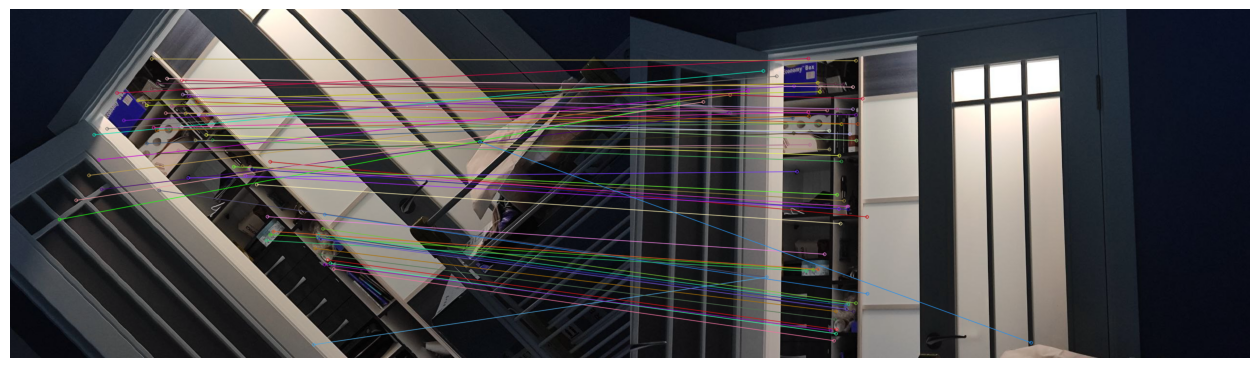

In [62]:
img1 = cv2.imread("1.jpg")

kp1,des1 = extract_features(img1,'sift')

img2 = cv2.imread("2.jpg")
kp2,des2 = extract_features(img2,'sift')

print(kp1,des1)

matches = match_features(des1, des2, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.275)
print('Number of matches after filtering:', len(matches))
visualize_matches(img1, kp1, img2, kp2, matches)


По картинкам видно, что методом SIFT точек находится достаточно много. Методом ORB при той же точности точек находится значительно меньше.



Найдем 2 набора точек: точки источника и результирующие точки для отправки в алгоритм построения матрицы.

In [63]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)


In [64]:
def estimate_partial_transform(cur_matched_kp, prev_matched_kp ,method):
    """
    
    :param matched_keypoints: output of match_keypoints util function; tuple of (cur_matched_kp, prev_matched_kp)
    :return: transform as list of [dx, dy, da]
    """
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp),
                                           np.array(cur_matched_kp),method=method)[0] #Тут как бы можно играться с тем как будут фильтроватся точки 
                                                                                          #cv2.LMEDS один из параметров который напрямую влияет  
      
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    return [dx, dy, da], transform

In [65]:
#m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
m , M  = estimate_partial_transform(dst_pts,src_pts, cv2.LMEDS)



print(" cropped matrix = ", M)
print(" rotation = ", m[2]*360/(2*math.pi))
print("move x, move y = " ,m[0],m[1])
print(" scale: ",np.sqrt(M[0, 0]**2 + M[1, 0]**2))
afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)


#Создаем матрицу из 4х левых верхних значений матрицы
R = afine_transform_matrix[:2, :2]
#Делаем сингулярное разложение: 
U, W, Vt = np.linalg.svd(R)
#Вычисляем:
rotation = np.dot(U, Vt)
scaling = np.diag(W)
translation = afine_transform_matrix[:2, 2:]
print(" rotation = ", rotation)
print("scale " ,scaling)
print(" translation ",translation)
#Отрисовывание точки на двух картинках


# Воссоздаем матрицу
rotation_scaling = np.dot(rotation, scaling)
    
# Создаем единичную матрицу
affine = np.eye(3)
affine[:2, :2] = rotation_scaling
affine[:2, 2] = translation.flatten()
print("   new affine matrix ", affine)


 cropped matrix =  [[   0.69792934   -0.71138267  336.21359668]
 [   0.73253156    0.68220281 -174.62669573]]
 rotation =  46.38568947267071
move x, move y =  336.213596680761 -174.6266957269082
 scale:  1.011784490975769
 rotation =  [[ 0.69096032 -0.72289269]
 [ 0.72289269  0.69096032]]
scale  [[1.01188342 0.        ]
 [0.         0.98552817]]
 translation  [[ 336.21359668]
 [-174.62669573]]
   new affine matrix  [[   0.69917129   -0.71243111  336.21359668]
 [   0.73148313    0.68096086 -174.62669573]
 [   0.            0.            1.        ]]


Мы видим, что вращение составило 46,3 градуса, что соотвсетствует картинке

Смещение -118 и 353 единицы
Скалирование 1.012 что также примерно соответствует картине.

Также мы видим, что восстановленная матрица совпадает с разложенной.



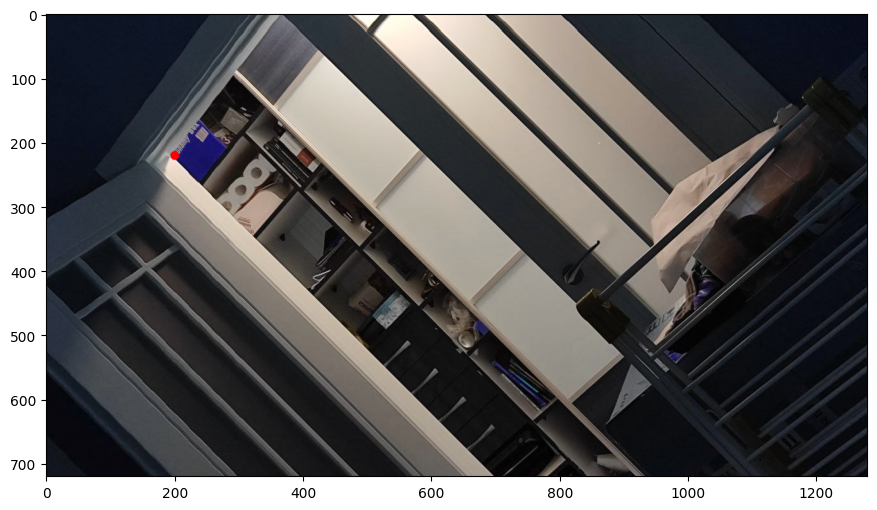

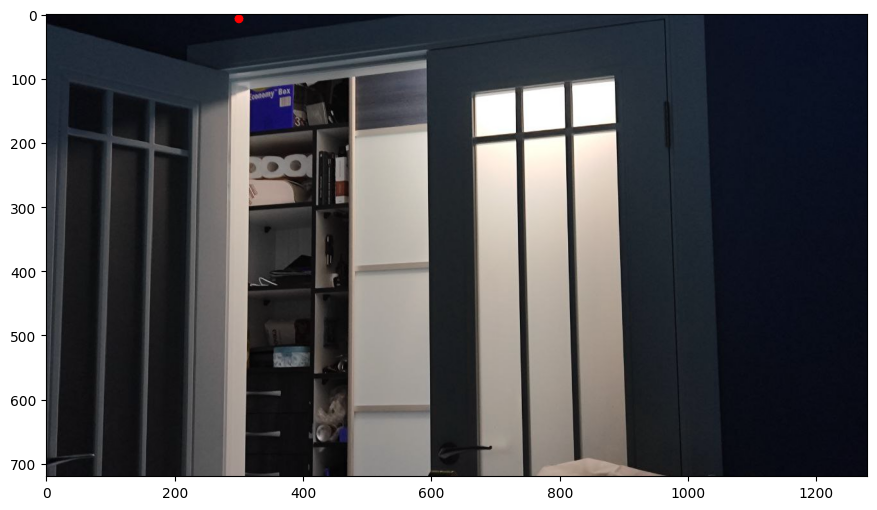

In [66]:
#Нарисуем точку и перенесем ее на повернутое изображение:



img1 = cv2.imread("1.jpg")
img2 = cv2.imread("2.jpg")
# Зададим координаты точки:
obs_point = ([200,220,0])  
#Нарисуем точку и на первой картинке:
img1s = cv2.circle(img1, (int(obs_point[0]),int(obs_point[1])), radius=7, color=(255, 0, 0), thickness=-1)   
plt.figure(figsize=(16, 6), dpi=100)
plt.imshow(img1s)   
#Изменим координаты точки умножением ее на матрицу
obs_point_new =np.dot(obs_point,afine_transform_matrix  )
img2s = cv2.circle(img2, (int(obs_point_new[0]),int(obs_point_new[1])), radius=7, color=(255, 0, 0), thickness=-1)

#
plt.figure(figsize=(16, 6), dpi=100)
plt.imshow(img2s)  

Найти точку на новом изображении не получилось. Перепробовал много вариантов.

In [68]:

FEATURE_METHOD_EXTRACTING = 'sift' # 'orb'

#cap = cv2.VideoCapture("videoplayback.mp4")
cap = cv2.VideoCapture("cercov360.mp4")


# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video file")
#Прочитаем первый кадр 
ret, frame = cap.read()
#kp_prev,des_prev = extract_features(frame,FEATURE_METHOD_EXTRACTING)

#src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
(h,w) = frame.shape[0:2]

observation_point = ([250,180])
frame = cv2.circle(frame, observation_point, radius=0, color=(0, 0, 255), thickness=-1)

cv2.imshow('frame',frame)
kp_prev,des_prev = extract_features(frame,FEATURE_METHOD_EXTRACTING)
#center = (w//2,h//2)
fourcc = cv2.VideoWriter_fourcc(*'FMP4')
video=cv2.VideoWriter('processed.avi',fourcc,30,(w,h))
#Считываем кадр за кадром:
counter = 0
while(cap.isOpened()):
        
#Выполняем чтение кадра:
    ret, frame = cap.read()  
    # Счетчик для остановки после определенного количества кадров
    counter+=1  
    
    if ret == True:
        
        
        #Находим особые точки кадра
        kp,des = extract_features(frame,FEATURE_METHOD_EXTRACTING)
        matches = match_features(des, des_prev, matching='BF', detector=FEATURE_METHOD_EXTRACTING, sort=True) #'FLANN'
        print('Number of matches before filtering:', len(matches))
        matches = filter_matches_distance(matches, 0.145)
        print('Number of matches after filtering:', len(matches))
        src_pts = np.float32([kp[mat.queryIdx].pt for mat in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_prev[mat.trainIdx].pt for mat in matches]).reshape(-1, 1, 2)
        m , M = estimate_partial_transform(dst_pts,src_pts, cv2.LMEDS)
        
        observation_point =observation_point[:2]@M   
        frame = cv2.circle(frame, (int(observation_point[0]),int(observation_point[1])), radius=10, color=(255, 0, 0), thickness=-1)
        cv2.imshow('frame',frame)
        
        kp_prev,des_prev = kp,des       
        
        video.write(frame)  
        print(" frame number ", counter)  
                   
        
    if cv2.waitKey(1) & 0xFF == ord('q') or ret==False or counter>1250:
        #Если кадр не считался, значит видео закончилось. Закрываем Видеокапче, закрываем окна кадров, завершаем видео
       cap.release()
       cv2.destroyAllWindows()
       video.release()
       print("everything is released")  
       break 

Number of matches before filtering: 2194
Number of matches after filtering: 2173
 frame number  1
Number of matches before filtering: 2194
Number of matches after filtering: 2172
 frame number  2
Number of matches before filtering: 2198
Number of matches after filtering: 2180
 frame number  3
Number of matches before filtering: 2198
Number of matches after filtering: 2198
 frame number  4
Number of matches before filtering: 2197
Number of matches after filtering: 2186
 frame number  5
Number of matches before filtering: 2197
Number of matches after filtering: 2188
 frame number  6
Number of matches before filtering: 2196
Number of matches after filtering: 2168
 frame number  7
Number of matches before filtering: 2209
Number of matches after filtering: 1532
 frame number  8
Number of matches before filtering: 2208
Number of matches after filtering: 2186
 frame number  9
Number of matches before filtering: 2206
Number of matches after filtering: 2195
 frame number  10
Number of matches b

Вывод:  Слежение не получилось. В моменты вращения камеры точка крутится ровно в другую сторону, т.е реагирует на изменение движения. Появление полей и элемента летательного аппарата особо не влияет на точку слежения.


